# Class 8 - 20.5.19

# `pandas`, `xarray` and Modeling

## String DataFrames

The raw data we have can sometimes come in the form of strings. Pandas support string DataFrames and allows for manipulation of these objects.

Note: I'm currently not discussing "bioinformatic sequences" of `ATGC` - these have a special `Seq` class in the Biopython package, the workhorse of Python bioinformatics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df_str = pd.DataFrame(['a', 'b', 'c', 'D  ', 'EFG', 'hij', 'k', '', ' LMNOP', 'QRST', 'UV', ' wxy', 'z'],
                      columns=['alpha'])
df_str

,alpha
0,a
1,b
2,c
3,D
4,EFG
5,hij
6,k
7,
8,LMNOP
9,QRST


To access the varienty of string methods in pandas, use the `.str` attribute of a Series.

In [2]:
df_str.alpha.str.lower()

0          a
1          b
2          c
3        d  
4        efg
5        hij
6          k
7           
8      lmnop
9       qrst
10        uv
11       wxy
12         z
Name: alpha, dtype: object

In [3]:
df_str.alpha.str.strip()  # remove whitespaces

0         a
1         b
2         c
3         D
4       EFG
5       hij
6         k
7          
8     LMNOP
9      QRST
10       UV
11      wxy
12        z
Name: alpha, dtype: object

When parsing `.csv` data, the column names can sometimes be unorderly, having whitespaces and different capitalization conventions. Here's an example of how to make them look alike:

In [4]:
# Assume we parsed this DataFrame from some third-party source
csv_df = pd.DataFrame([], columns=[' Name', 'Age ', ' Gender ', 'Is single', 'Has children', 'Num of Children'])
csv_df

,Name,Age,Gender,Is single,Has children,Num of Children


Due to the fact that a column of a DataFrame is a regular Index object, we can use our string methods to make it look better:

In [5]:
csv_df.columns = csv_df.columns.str.strip()\
                               .str.lower()\
                               .str.replace(' ', '_')
csv_df  # stripped of leading and trailing whitespaces, 
        # removed capital letters
        # and replaced spaces with underscores

,name,age,gender,is_single,has_children,num_of_children


We can get the first letter in each entry:

In [6]:
df_str.alpha.str.get(0)

0       a
1       b
2       c
3       D
4       E
5       h
6       k
7     NaN
8        
9       Q
10      U
11       
12      z
Name: alpha, dtype: object

You can also use regular expressions to extract patterns from each row of the Series.

In the mean time, a summary of all the string-related methods in pandas can be found [here](http://pandas.pydata.org/pandas-docs/stable/text.html). They contain most of the Pythonic string-related operations.

Note: String operations aren't as fast as numerical computations since they're currently implemented mostly with Python in the backend, and not C.

## Pandas Concatenation

Similar to numpy arrays, Series and DataFrame objects can be concatenated as well. The indexes of the pandas objects is what usually makes this operation non-trivial.

While this discussion might not seem to you super important, it's actually more useful than you'd think. Thinking of our different sets of data in terms of a large database can sometimes be a good analogy.

A full tutorial on this manner can be found in the official pandas tutorial, right [here](https://pandas.pydata.org/pandas-docs/stable/merging.html).

In [7]:
ser1 = pd.Series(['a', 'b', 'c'], index=[1, 2, 3])
ser2 = pd.Series(['d', 'e', 'f'], index=[4, 5, 6])
pd.concat([ser1, ser2])  # row-wise (axis=0) by default

1    a
2    b
3    c
4    d
5    e
6    f
dtype: object

In [8]:
# This simple behavior can be achieved using the append method
ser1.append(ser2)

1    a
2    b
3    c
4    d
5    e
6    f
dtype: object

In [9]:
df1 = pd.DataFrame([['a', 'A'], ['b', 'B']], columns=['let', 'LET'], index=[0, 1])
df2 = pd.DataFrame([['c', 'C'], ['d', 'D']], columns=['let', 'LET'], index=[2, 3])
pd.concat([df1, df2])  # again, along the first axis

,let,LET
0,a,A
1,b,B
2,c,C
3,d,D


In [10]:
df1 = pd.DataFrame([['a', 'A'], ['b', 'B']], columns=['let1', 'LET1'], index=[0, 1])
df2 = pd.DataFrame([['c', 'C'], ['d', 'D']], columns=['let2', 'LET2'], index=[2, 3])
pd.concat([df1, df2])  # pandas can't make the column index compatible, so it resorts to columnar concat
# the same result is achieved by pd.concat([df1, df2], axis=1)

/home/hagai/miniconda3/envs/course/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,LET1,LET2,let1,let2
0,A,NaN,a,NaN
1,B,NaN,b,NaN
2,NaN,C,NaN,c
3,NaN,D,NaN,d


If we wish to keep the integrity of the indices, we can use the `verify_integrity` keyword:

In [11]:
df1 = pd.DataFrame([['a', 'A'], ['b', 'B']], columns=['let', 'LET'], index=[0, 1])
df2 = pd.DataFrame([['c', 'C'], ['d', 'D']], columns=['let', 'LET'], index=[0, 2])
pd.concat([df1, df2], verify_integrity=True)

ValueError: Indexes have overlapping values: Int64Index([0], dtype='int64')

If we don't care about the indices, we can just ignore them:

In [12]:
pd.concat([df1, df2], ignore_index=True)  # creates a new index

,let,LET
0,a,A
1,b,B
2,c,C
3,d,D


We can also create a new MultiIndex if it makes more sense:

In [13]:
pd.concat([df1, df2], keys=['df1', 'df2'])  # "remembers" the origin of the data, super useful!

let LET
df1 0   a   A
    1   b   B
df2 0   c   C
    2   d   D

A real world example of concatenation is when we wish to join two datasets taken at different times. For example, if we conducted in day 1 measurements at times 8:00, 10:00, 14:00 and 16:00, but during day 2 we were a bit dizzy, and conducted the measurements at 8:00, 10:00, 13:00 and 16:30. On top of that, we recorded another parameter that we forget to measure at day 1.

The default concatenation behavior of pandas keeps all the data. In database terms (SQL people rejoice!) it's called an "outer join":

In [14]:
# Prepare mock data
times_day1 = pd.to_datetime(['08:00', '10:00', '14:00', '16:00'], format='%H:%M')
times_day2 = pd.to_datetime(['08:00', '10:00', '13:00', '16:30'], format='%H:%M')

temp_day1 = [36.6, 36.7, 37.0, 36.8]
temp_day2 = [35.9, 36.1, 36.5, 36.2]

humid_day1 = [30., 31., 30.4, 30.4]
humid_day2 = [32.2, 34.2, 30.9, 32.6]

light_day2 = [200, 130, 240, 210]

data_day1 = pd.DataFrame({'temp': temp_day1, 'humid': humid_day1}, index=times_day1)
data_day2 = pd.DataFrame({'temp': temp_day2, 'humid': humid_day2,
                          'light': light_day2}, index=times_day2)
data_day1

,temp,humid
1900-01-01 08:00:00,36.6,30.0
1900-01-01 10:00:00,36.7,31.0
1900-01-01 14:00:00,37.0,30.4
1900-01-01 16:00:00,36.8,30.4


In [15]:
data_day2

,temp,humid,light
1900-01-01 08:00:00,35.9,32.2,200
1900-01-01 10:00:00,36.1,34.2,130
1900-01-01 13:00:00,36.5,30.9,240
1900-01-01 16:30:00,36.2,32.6,210


In [16]:
# Outer join
pd.concat([data_day1, data_day2], join='outer')  # outer join is the default behavior  

/home/hagai/miniconda3/envs/course/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,humid,light,temp
1900-01-01 08:00:00,30.0,NaN,36.6
1900-01-01 10:00:00,31.0,NaN,36.7
1900-01-01 14:00:00,30.4,NaN,37.0
1900-01-01 16:00:00,30.4,NaN,36.8
1900-01-01 08:00:00,32.2,200.0,35.9
1900-01-01 10:00:00,34.2,130.0,36.1
1900-01-01 13:00:00,30.9,240.0,36.5
1900-01-01 16:30:00,32.6,210.0,36.2


To take the intersection of the columns we have to use inner join. The intersection is all the columns that are common in all datasets.

In [17]:
# Inner join - the excess data column was dropped (index is still not unique)
pd.concat([data_day1, data_day2], join='inner')

,temp,humid
1900-01-01 08:00:00,36.6,30.0
1900-01-01 10:00:00,36.7,31.0
1900-01-01 14:00:00,37.0,30.4
1900-01-01 16:00:00,36.8,30.4
1900-01-01 08:00:00,35.9,32.2
1900-01-01 10:00:00,36.1,34.2
1900-01-01 13:00:00,36.5,30.9
1900-01-01 16:30:00,36.2,32.6


One can also specify the exact columns that should be the result of the join operation using the `columns` keyword. All in all, this basic functionality is easy to understand and allows for high flexibility. If you wish to conduct a more sophisticated join operation, you should use `pd.merge()`, as we'll show below.

Finally, joining on the columns will require the indices to be unique:

In [18]:
pd.concat([data_day1, data_day2], join='inner', axis='columns')

,temp,humid,temp,humid,light
1900-01-01 08:00:00,36.6,30.0,35.9,32.2,200
1900-01-01 10:00:00,36.7,31.0,36.1,34.2,130


This doesn't look so good. The columns are a mess and we're barely left with any data. The right operation for this job is a `pd.merge`.

Merging two DataFrames into one is done in the following manner:

In [19]:
times = pd.to_datetime(['08:00', '10:00', '14:00', '16:00'], format='%H:%M')

temp_day1 = [36.6, 36.7, 37.0, 36.8]
humid_day1 = [30., 31., 30.4, 30.4]

df_temp = pd.DataFrame({'temp': temp_day1}, index=times)
df_humid = pd.DataFrame({'humid': humid_day1}, index=times)

pd.merge(df_temp, df_humid, right_index=True, left_index=True)  # merge with indices

,temp,humid
1900-01-01 08:00:00,36.6,30.0
1900-01-01 10:00:00,36.7,31.0
1900-01-01 14:00:00,37.0,30.4
1900-01-01 16:00:00,36.8,30.4


In [20]:
# Slightly different data example
temp_day1 = [36.6, 36.7, 37.0, 36.8]
humid_day1 = [30., 31., 30.4, 30.4]

temp_day2 = [37.1, 36.6, 36.6, 36.7]

df_day1 = pd.DataFrame({'temp': temp_day1, 'humid': humid_day1}, index=times)
df_day2 = pd.DataFrame({'temp': temp_day2}, index=times)

df_day1

,temp,humid
1900-01-01 08:00:00,36.6,30.0
1900-01-01 10:00:00,36.7,31.0
1900-01-01 14:00:00,37.0,30.4
1900-01-01 16:00:00,36.8,30.4


In [21]:
# Merging (as a method, not a procedure)
df_day1.merge(df_day2, left_index=True, right_index=True)
# This merge "remembers" the origin of the data, the "suffixes" keyword allows us to determine the new suffix

,temp_x,humid,temp_y
1900-01-01 08:00:00,36.6,30.0,37.1
1900-01-01 10:00:00,36.7,31.0,36.6
1900-01-01 14:00:00,37.0,30.4,36.6
1900-01-01 16:00:00,36.8,30.4,36.7


In [22]:
# One more example, more similar to traditional databases
mouse_id = [511, 512, 513, 514]
meas1 = [67, 66, 89, 92]
meas2 = [45, 45, 65, 61]

data1 = pd.DataFrame({'id': mouse_id, 'blood_vol': meas1})
data2 = pd.DataFrame({'id': mouse_id, 'monocytes': meas2})
data1

,id,blood_vol
0,511,67
1,512,66
2,513,89
3,514,92


In [23]:
data1.merge(data2)  # merge identified that the only "key" connecting the two tables was the 'id' key

,id,blood_vol,monocytes
0,511,67,45
1,512,66,45
2,513,89,65
3,514,92,61


Database-like operation is a very broad topic in pandas, and it's another great example of why should you keep your data in a DataFrame.

If you feel like this join and merge operation might help you, don't hesitate to consult the official documents on this topic, linked [here](https://pandas.pydata.org/pandas-docs/stable/merging.html) (again).

## GroupBy

Yet another SQL-like feature that pandas posses is the group-by operation, sometimes known as "split-apply-combine".

In [24]:
# Mock data
subject = [100, 101, 102, 106, 108, 109]
dead = [True, True, False, True, False, False]
took_med = [False, True, True, False, False, True]
val1 = np.random.random(6)
val2 = np.random.random(6)
df = pd.DataFrame({'dead': dead, 'took_med': took_med,
                   'val1': val1, 'val2': val2}, index=subject)
df

,dead,took_med,val1,val2
100,True,False,0.977566,0.094403
101,True,True,0.433096,0.377533
102,False,True,0.226830,0.631251
106,True,False,0.851649,0.697016
108,False,False,0.680675,0.379838
109,False,True,0.310411,0.970776


The most sensible thing to do is to group by either the "dead" or the "took_med" column (or both). This is the "split" part.

In [25]:
grouped = df.groupby('dead')
grouped  # DataFrameGroupBy object - intermediate object ready to be evaluated

This intermediate object is an internal pandas representation which should allow it to run very fast computation the moment we want to actually _know_ something about these groups. Assuming we want the mean of `val1`, as long as we won't specifically write `grouped.mean()` pandas will do very little in terms of actual computation. It's called "lazy evaluation".

The intermediate object has some useful attributes:

In [26]:
grouped.groups

{False: Int64Index([102, 108, 109], dtype='int64'),
 True: Int64Index([100, 101, 106], dtype='int64')}

In [27]:
len(grouped)  # True and False

2

If we wish to run some actual processing, we have to use an aggregation function:

In [28]:
grouped.sum()

,took_med,val1,val2
dead,,,
False,2.0,1.217916,1.981865
True,1.0,2.262310,1.168951


In [29]:
grouped.mean()

,took_med,val1,val2
dead,,,
False,0.666667,0.405972,0.660622
True,0.333333,0.754103,0.389650


In [30]:
grouped.size()

dead
False    3
True     3
dtype: int64

If we just wish to see one of the groups, we can use `get_group()`:

In [31]:
grouped.get_group(True)

,took_med,val1,val2
100,False,0.977566,0.094403
101,True,0.433096,0.377533
106,False,0.851649,0.697016


We can also call several functions at once using the `.agg` attribute:

In [32]:
grouped.agg([np.sum, np.var])

took_med                val1                val2          
           sum       var       sum       var       sum       var
dead                                                            
False      2.0  0.333333  1.217916  0.058343  1.981865  0.087949
True       1.0  0.333333  2.262310  0.081248  1.168951  0.090896

GroupBy offers many more features, documented [online](http://pandas.pydata.org/pandas-docs/stable/groupby.html).

## Exercise

1. _Strings in pandas:_ 
    - Generate a 1000-length `pd.DataFrame` filled with 3-letter strings. Use the `string` module, and others, to generate it quickly.
    - Add a column indicating if the string in this row has a `z` in its 2nd character.
    - Add a third column swapping the case of the 3-letter string in these specific lines (`azI` to `AZi`). In the other lines it should remain uncapitalized.

2. _Concatenation:_
    - Create three DataFrames with random values and shapes of (10x2), (10x1), (15x3). Their index should be simple ordinal integers, and their column names should differ.
    - Concatenate these DFs over the second axis using `pd.concat`.
    - Concatenate these DFs over the second axis using `pd.merge`.

3. _GroupBy:_
    - Create a DataFrame with two columns, 10k entries in length. The first should be a "flag" column, having a value of either 0 or 1, randomly. The second should be A sine wave from 0 to 20$\pi$, length of 10k. This simulates measuring a parameter from two distinct groups.
    - GroupBy the DataFrame, creating a GroupBy object.
    - Plot and overlay the two traces (of the two flags).
    - Use the `.rolling()` method to create a rolling average window of length 5 and overlay the result.


## Exercise solutions below...

In [33]:
# 1
import string
import numpy as np
import pandas as pd

# Generate the array
letters = list(string.ascii_lowercase)
size = 1000
num_of_letters = 3 
chosen = np.random.choice(letters, size*num_of_letters)
chosen = chosen.reshape((size, num_of_letters))
df = pd.DataFrame(chosen, columns=['a', 'b', 'c'])
df['letters'] = df.a.str.cat(df.b.str.cat(df.c))

# Filter
char = 'z'
df['no_z'] = df['letters'].str.find(char) != 1
df['swap'] = df['letters'].where(df['no_z'], other=df['letters'].str.upper())
df.head(20)

,a,b,c,letters,no_z,swap
0,n,f,w,nfw,True,nfw
1,g,s,t,gst,True,gst
2,n,r,e,nre,True,nre
3,t,t,z,ttz,True,ttz
4,u,z,c,uzc,False,UZC
5,u,i,s,uis,True,uis
6,m,t,d,mtd,True,mtd
7,e,a,w,eaw,True,eaw
8,l,a,e,lae,True,lae
9,m,d,v,mdv,True,mdv


In [34]:
# 2
dfa = pd.DataFrame(np.random.random((10, 2)), columns=['a', 'b'])
dfb = pd.DataFrame(np.random.random((10, 1)), columns=['c'])
dfc = pd.DataFrame(np.random.random((15, 3)), columns=['d', 'e', 'f'])

# Using concat
print(pd.concat([dfa, dfb, dfc], axis=1))
# Using merge
pd.merge(pd.merge(dfa, dfb, how='outer', left_index=True, right_index=True), 
         dfc, how='outer', left_index=True, right_index=True)

           a         b         c         d         e         f
0   0.099440  0.473808  0.022436  0.087550  0.938060  0.418129
1   0.421797  0.347943  0.022418  0.870642  0.968739  0.605189
2   0.765716  0.525893  0.594869  0.329451  0.975502  0.101556
3   0.345165  0.446720  0.238288  0.541351  0.391899  0.549402
4   0.301057  0.459601  0.812017  0.932113  0.480305  0.677415
5   0.263400  0.796951  0.545263  0.015327  0.815814  0.305352
6   0.228221  0.266079  0.377693  0.818462  0.322144  0.047977
7   0.887580  0.375648  0.803225  0.445266  0.731440  0.432320
8   0.882566  0.421746  0.714760  0.153811  0.180213  0.226544
9   0.668532  0.601916  0.866854  0.709304  0.449055  0.693811
10       NaN       NaN       NaN  0.383852  0.579978  0.129316
11       NaN       NaN       NaN  0.330585  0.846395  0.856580
12       NaN       NaN       NaN  0.884055  0.591412  0.184183
13       NaN       NaN       NaN  0.060337  0.443717  0.278496
14       NaN       NaN       NaN  0.079485  0.873294  0

,a,b,c,d,e,f
0,0.099440,0.473808,0.022436,0.087550,0.938060,0.418129
1,0.421797,0.347943,0.022418,0.870642,0.968739,0.605189
2,0.765716,0.525893,0.594869,0.329451,0.975502,0.101556
3,0.345165,0.446720,0.238288,0.541351,0.391899,0.549402
4,0.301057,0.459601,0.812017,0.932113,0.480305,0.677415
5,0.263400,0.796951,0.545263,0.015327,0.815814,0.305352
6,0.228221,0.266079,0.377693,0.818462,0.322144,0.047977
7,0.887580,0.375648,0.803225,0.445266,0.731440,0.432320
8,0.882566,0.421746,0.714760,0.153811,0.180213,0.226544
9,0.668532,0.601916,0.866854,0.709304,0.449055,0.693811


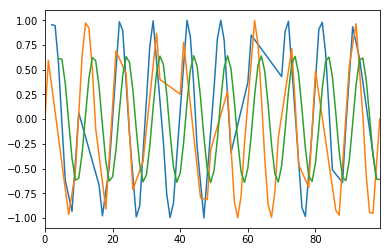

In [35]:
# 3
vals = np.array([0, 1])
needed = 100
stop = 20 * np.pi
chosen = np.random.choice(vals, needed)
df = pd.DataFrame({'flag': chosen, 'val': np.sin(np.linspace(start=0, stop=stop, num=needed))})

window_size = 5
grouped = df.groupby('flag')
grouped.val.plot()

df.val.rolling(window=window_size).mean().plot()

## IntervalIndex

Pandas has a __TON__ of features and small implementation details that are there to make your life simpler. A small example, just to make you look for these deep in the documentation, is an `IntervalIndex`.

`IntervalIndex` is a type of index, just like a `DatetimeIndex` that we've seen many times, or a simple integer index. This index is special because it contain a start and a stop "time", and values can be included or excluded in this range.

In [36]:
df = pd.DataFrame([0, 1, 2, 3], index=pd.IntervalIndex.from_breaks((0, 1, 2, 3, 4)),
                  columns=['data'])
df  # notice the index

,data
"(0, 1]",0
"(1, 2]",1
"(2, 3]",2
"(3, 4]",3


In [37]:
# Select a label on the edge of the index
df.loc[2]  # label-based, i.e. index-based and not value-based

data    1
Name: (1, 2], dtype: int64

In [38]:
df.loc[[1, 2]]

,data
"(0, 1]",0
"(1, 2]",1


In [39]:
# Select a label contained in the index
df.loc[1.5]

data    1
Name: (1, 2], dtype: int64

There are types of datasets that "demand" an `IntervalIndex`, 
in the sense that it's very natural to use them to represent the data. 
For example, if you sample data from an electrode every microsecond, 
then the measurement at time `t` represents the values in times `(t-us, t]`.

# Higher Dimensionality - `xarray`

Pandas is amazing, but has its limits. A `DataFrame` can be a multi-dimensional container when using a `MultiIndex`, but it's limited to a subset of uses in which another layer of indexing makes sense.

In many occasions, however, our data is truly high-dimensional. A simple case could be electrophysiological recordings, or calcium traces. In these cases we have several indices (some can be categorical), like "Sex", "AnimalID", "Date", "TypeOfExperiment" and perhaps a few more. But the data itself is a vector of numbers representing voltage or fluorescence. Having this data in a DataFrame seems a bit "off" - what are the columns on this DF? Is each column a voltage measurement? Or if each column is a measurement, how do you deal with the indices? We can use nested columns (`MultiIndex` the columns), but it's not a very modular approach.

This is a classic example where pandas DF "fail", and indeed pandas used to have a higher-dimensionality container named `Panel`. However, late 2016 pandas devs deprecated it, publicly announcing that they intend to drop support for `Panel`s sometime in the future, and whoever needs a higher-dimensionality container should use `xarray`.

Thus, in essence `xarray` is a labeled n-dimensional array. Just like a DataFrame is a labeled 2D array, i.e. with names to its axes rather than numbers, in `xarray` each dimension has a name (`time`, `temp`, `voltage`) and its indices ("coordinates") can also have labels (like a timestamp, for example). In addition, each `xarray` object also has metadata attached to it, in which we can write details that do not fit a columnar structure (experimenter name, hardware and software used for acquisition, etc.).

## DataArray

In [40]:
import numpy as np
import xarray as xr


da = xr.DataArray(np.random.random((10, 2)))
da

<xarray.DataArray (dim_0: 10, dim_1: 2)>
array([[0.811788, 0.451999],
       [0.329244, 0.054251],
       [0.395648, 0.266465],
       [0.964907, 0.088796],
       [0.222309, 0.330811],
       [0.13952 , 0.646182],
       [0.44157 , 0.422225],
       [0.658387, 0.152891],
       [0.563514, 0.672669],
       [0.005156, 0.976007]])
Dimensions without coordinates: dim_0, dim_1

The basic building block of `xarray` is a DataArray, an n-dimensional counter part of a pandas' Series. It has two dimensions, just like the numpy array that its based upon. We didn't specify names for these dimensions, so currently they're called `dim_0` and `dim_1`. We also didn't specify coordinates (indices), so the printout doesn't report of any coordinates for the data.

In [41]:
da.values  # just like pandas

array([[0.8117881 , 0.45199918],
       [0.32924403, 0.05425098],
       [0.39564767, 0.26646539],
       [0.96490725, 0.08879555],
       [0.22230903, 0.33081134],
       [0.13952006, 0.64618184],
       [0.44156953, 0.42222452],
       [0.6583871 , 0.15289086],
       [0.56351422, 0.67266863],
       [0.0051561 , 0.97600701]])

In [42]:
da.coords

Coordinates:
    *empty*

In [43]:
da.dims

('dim_0', 'dim_1')

In [44]:
da.attrs

OrderedDict()

We'll add coordinates and dimension names and see how indexing works:

In [45]:
dims = ('time', 'repetition')
coords = {'time': np.linspace(0, 1, num=10),
          'repetition': np.arange(2)}
da2 = xr.DataArray(np.random.random((10, 2)), dims=dims, coords=coords)
da2

<xarray.DataArray (time: 10, repetition: 2)>
array([[0.792435, 0.466192],
       [0.342819, 0.142081],
       [0.622309, 0.682035],
       [0.294185, 0.600305],
       [0.4853  , 0.060108],
       [0.829469, 0.720694],
       [0.776835, 0.957733],
       [0.473218, 0.519051],
       [0.803736, 0.374799],
       [0.717004, 0.234577]])
Coordinates:
  * time        (time) float64 0.0 0.1111 0.2222 0.3333 ... 0.7778 0.8889 1.0
  * repetition  (repetition) int64 0 1

In [46]:
da2[[0, 1]]  # positional
da2.loc[0.1:0.3, 1]  # rows 1-2 in the second column

<xarray.DataArray (time: 2)>
array([0.142081, 0.682035])
Coordinates:
  * time        (time) float64 0.1111 0.2222
    repetition  int64 1

In [47]:
da2.isel(time=slice(3, 7))  # dimension name and integer label (sel = select)

<xarray.DataArray (time: 4, repetition: 2)>
array([[0.294185, 0.600305],
       [0.4853  , 0.060108],
       [0.829469, 0.720694],
       [0.776835, 0.957733]])
Coordinates:
  * time        (time) float64 0.3333 0.4444 0.5556 0.6667
  * repetition  (repetition) int64 0 1

In [48]:
da2.sel(repetition=[0])  # dimension name and coordinate label

<xarray.DataArray (time: 10, repetition: 1)>
array([[0.792435],
       [0.342819],
       [0.622309],
       [0.294185],
       [0.4853  ],
       [0.829469],
       [0.776835],
       [0.473218],
       [0.803736],
       [0.717004]])
Coordinates:
  * time        (time) float64 0.0 0.1111 0.2222 0.3333 ... 0.7778 0.8889 1.0
  * repetition  (repetition) int64 0

Other operations on DataArrays, such as computations, grouping and such, are done very similarly to DataFrames and numpy arrays.

## Dataset

A Dataset is to a DataArray what a DataFrame is to a Series. In other words, it's a collection of DataArrays that share coordinates.

In [49]:
da2  # a reminder. We notice that this could've been a DataFrame as well

<xarray.DataArray (time: 10, repetition: 2)>
array([[0.792435, 0.466192],
       [0.342819, 0.142081],
       [0.622309, 0.682035],
       [0.294185, 0.600305],
       [0.4853  , 0.060108],
       [0.829469, 0.720694],
       [0.776835, 0.957733],
       [0.473218, 0.519051],
       [0.803736, 0.374799],
       [0.717004, 0.234577]])
Coordinates:
  * time        (time) float64 0.0 0.1111 0.2222 0.3333 ... 0.7778 0.8889 1.0
  * repetition  (repetition) int64 0 1

In [50]:
ds = xr.Dataset({'ephys': da2,
                 'calcium': ('time', np.random.random(10))},
                attrs={'AnimalD': 701,
                       'ExperimentType': 'double',
                       'Sex': 'Male'})
ds

<xarray.Dataset>
Dimensions:     (repetition: 2, time: 10)
Coordinates:
  * time        (time) float64 0.0 0.1111 0.2222 0.3333 ... 0.7778 0.8889 1.0
  * repetition  (repetition) int64 0 1
Data variables:
    ephys       (time, repetition) float64 0.7924 0.4662 0.3428 ... 0.717 0.2346
    calcium     (time) float64 0.12 0.8039 0.7131 ... 0.2509 0.644 0.03486
Attributes:
    AnimalD:         701
    ExperimentType:  double
    Sex:             Male

In [51]:
ds['ephys']  # individual DataArrays can be dissimilar in shape

<xarray.DataArray 'ephys' (time: 10, repetition: 2)>
array([[0.792435, 0.466192],
       [0.342819, 0.142081],
       [0.622309, 0.682035],
       [0.294185, 0.600305],
       [0.4853  , 0.060108],
       [0.829469, 0.720694],
       [0.776835, 0.957733],
       [0.473218, 0.519051],
       [0.803736, 0.374799],
       [0.717004, 0.234577]])
Coordinates:
  * time        (time) float64 0.0 0.1111 0.2222 0.3333 ... 0.7778 0.8889 1.0
  * repetition  (repetition) int64 0 1

## Exercise - Rat Visual Stimulus Experiment Database

You're measuring the potential of neurons in a rat's brain over time in response to flashes of light
using a multi-electrode array surgically inserted into the rat's skull. Each trial is two seconds
long, and one second into the trial a short, 100 ms, bright light is flashed at the animal. After 30 seconds
the experiment is replicated, for a total of 4 repetitions. The relevant parameters are the following:

- Rat ID.
- Experimenter name.
- Rat gender.
- Measured voltage (10 electrode, 10k samples representing two seconds).
- Stimulus index (mark differently the pre-, during- and post-stimulus time).
- Repetition number.

Mock data and model it, you can add more parameters if you feel so.

Experimental timeline:
```
       1s          100ms             0.9s             30s
Start -----> Flash -----> End flash -----> End trial -----> New trial
|                                                                    |
|--------------------------------------------------------------------|
                                   x4
```

### Methods and functions to implement

1. There should be a class holding this data table, `VisualStimData`, alongside
several methods for the analysis of the data. The class should have a `data`
attribute containing the data table, in a `xarray.DataArray` or a `xarray.Dataset`.

2. Write a function (not a method) that returns an instance of the class with mock data.
    ```python
    def mock_stim_data() -> VisualStimData:
        """ Creates a new VisualStimData instance with mock data """
    ```

    When simulating the recorded voltage, it's completely fine to not model spikes precisely,
    with leaky integration and so forth - randoming numbers and treating them as the recorded
    neural potential is fine. There are quite a few ways to model _real_ neurons,
    if so you wish, [brian](http://brian2.readthedocs.io/en/stable/index.html) being one
    of them. If your own research will benefit from knowing how to use these tools, this
    exercise is a great place to start familiarizing yourself with them.

3. Write a method that receives a repetition number, rat ID, and a list of electrode numbers,
and plots the voltage recorded from these electrodes. The single figure should be
divided into however many plots needed, depending on the length of the list of electrode
numbers.

    ```python
    def plot_electrode(self, rep_number: int, rat_id: int, elec_number: tuple=(0,)):
        """
        Plots the voltage of the electrodes in "elec_number" for the rat "rat_id" in the repetition
        "rep_number". Shows a single figure with subplots.
        """
    ```

4. To see if the different experimenters influence the measurements, write a method that
calculates the mean, standard deviation and median of the average voltage trace across all
repetitions, for each experimenter, and shows a bar plot of it.

    ```python
    def experimenter_bias(self):
        """ Shows the statistics of the average recording across all experimenters """
    ```

### Exercise solutions below...

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class VisualStimData:
    """
    Data and methods for the visual stimulus ePhys experiment.
    The data table itself is held in self.data, an `xarray` object.
    Inputs:
        data: xr.DataArray or xr.Dataset
    Methods:
         ...
    """
    def __init__(self, data: xr.Dataset, ):
        assert isinstance(data, xr.Dataset)
        self.data = data


    def plot_electrode(self, rep_number: int, rat_id: int, elec_number: tuple=(0,)):
        """
        Plots the voltage of the electrodes in "elec_number" for the rat "rat_id" in the repetition
        "rep_number". Shows a single figure with two subplots, for male and female rats.
        """
        fig, axes = plt.subplots(len(elec_number), 1)
        axes = np.array([axes]) if isinstance(axes, plt.Axes) else axes
        time = self.data['time']
        for ax, elec in zip(axes, elec_number):
            to_plot = self.data.sel(rep=rep_number, rat_id=rat_id, elec=elec)['volt'].values
            ax.plot(time, to_plot)
            ax.set_xlabel('Time [s]')
            ax.set_ylabel('Voltage [V]')
            ax.set_title(f'Electrode {elec}')

        fig.tight_layout()

    def experimenter_bias(self):
        """ Shows the statistics of the average recording across all experimenters """
        names = np.unique(self.data.coords['exp_name'].values)
        means = []
        stds = []
        medians = []
        for experimenter in names:
            data = self.data.sel(exp_name=experimenter)['volt'].values
            means.append(np.abs(data.mean()))
            stds.append(np.abs(data.std()))
            medians.append(np.abs(np.median(data)))

        # Plotting
        fig, ax = plt.subplots()
        x_locs = np.arange(len(names))
        width = 0.3
        rect0 = ax.bar(x_locs, means, width, color='C0')
        rect1 = ax.bar(x_locs + width, stds, width, color='C1')
        rect2 = ax.bar(x_locs - width, medians, width, color='C2')

        ax.set_xticks(x_locs)
        ax.set_xticklabels(names)
        ax.legend((rect0[0], rect1[0], rect2[0]), ('Mean', 'STD', 'Median'))
        ax.set_title('Experimenter Bias (absolute values)')
        ax.set_ylabel('Volts [V]')

In [14]:
def mock_stim_data() -> VisualStimData:
    """ Creates a new VisualStimData instance with mock data """
    num_of_animals = 20
    num_of_reps = 4
    reps = np.arange(num_of_reps, dtype=np.uint8)
    total_num_of_exp = num_of_animals * num_of_reps
    exp_number = np.arange(total_num_of_exp, dtype=np.uint32)
    
    rat_id_ints, rat_id = _generate_rat_data(num_of_animals)
    room_temp, room_humid = _generate_temp_hum_values(total_num_of_exp)
    experimenters = _generate_experimenter_names(num_of_animals, num_of_reps)
    rat_sex = _generate_rat_gender(num_of_animals, num_of_reps)
    stim, electrode_array, time, volt = _generate_voltage_stim(num_of_animals, num_of_reps)

    # Construct the Dataset - this could be done with a pd.MultiIndex as well
    ds = xr.Dataset({'temp': (['num'], room_temp),
                     'humid': (['num'], room_humid),
                     'volt': (['elec', 'time', 'rat_id', 'rep'], volt),
                     'stim': (['time'], stim)},
                    coords={'elec': electrode_array,
                            'time': time,
                            'rat_id': rat_id,
                            'rep': reps,
                            'exp_name': experimenters,
                            'sex': rat_sex,
                            'num': exp_number,
                            })

    ds.attrs['exp_date'] = pd.to_datetime('today')
    ds.attrs['rat_strain'] = 'Sprague Dawley'

    return VisualStimData(ds)
    
def _generate_rat_data(num_of_animals):
    rat_id_ints = np.random.choice(np.arange(100, 900), size=300, replace=False)
    rat_id = np.random.choice(rat_id_ints, size=num_of_animals, replace=False)
    return rat_id_ints, rat_id


def _generate_temp_hum_values(total_num_of_exp):
    room_temp = np.random.random(total_num_of_exp) * 3 + 23  # between 23 and 26 C
    room_humid = np.random.randint(30, 70, size=total_num_of_exp)
    return room_temp, room_humid

def _generate_experimenter_names(num_of_animals, num_of_reps):
    names = ['Dana', 'Motti', 'Sam', 'Daria']
    experimenters = np.random.choice(names, size=num_of_animals, replace=True)
    experimenters = np.tile(experimenters, num_of_reps)
    return experimenters

def _generate_rat_gender(num_of_animals, num_of_reps):
    sex = ['F', 'M']
    rat_sex = np.random.choice(sex, size=num_of_animals, replace=True)
    rat_sex = np.tile(rat_sex, num_of_reps)
    return rat_sex


def _generate_voltage_stim(num_of_animals, num_of_reps):
    pre_stim = 1  # seconds
    stim_time = 0.1  # seconds
    post_stim = 0.9  # seconds
    sampling_rate = 5000  # Hz
    freq = 1 / sampling_rate
    experiment_length = int(pre_stim + stim_time + post_stim)
    electrodes = 10
    samples = sampling_rate * experiment_length

    # Random voltage values from N(0.068, 0.0004)
    volt = 0.02 * np.random.randn(electrodes, samples, num_of_animals,
                                 num_of_reps).astype(np.float32) - 0.068  # in volts, not millivolts
    volt[volt > -0.02] = 0.04  # "spikes"
    time = pd.date_range(start=pd.to_datetime('today'), periods=experiment_length * sampling_rate,
                         freq=f'{freq}S')
    electrode_array = np.arange(electrodes, dtype=np.uint16)

    # Stim index - -1 is pre, 0 is stim, 1 is post
    stim = np.zeros(int(samples), dtype=np.int8)
    stim[:int(pre_stim*sampling_rate)] = -1
    stim[int((pre_stim + stim_time)*sampling_rate):] += 1
    return stim, electrode_array, time, volt

/home/hagai/miniconda3/envs/course/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


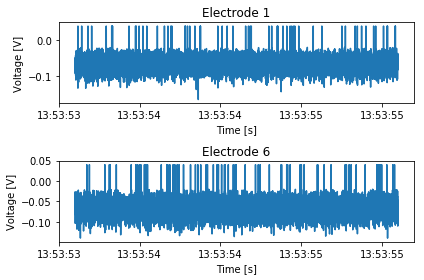

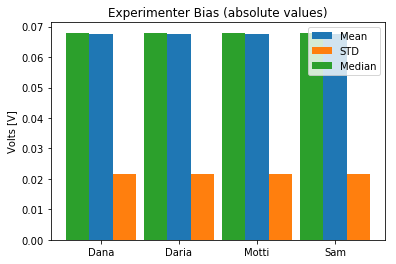

In [15]:
# Run the solution
stim_data = mock_stim_data()
ids = stim_data.data['rat_id']
arr = stim_data.plot_electrode(rep_number=2, rat_id=ids[0], elec_number=(1, 6))
stim_data.experimenter_bias()